In [1]:
import os
import config
import platform
v1, v2, v3 = config.spark_env(platform.node())
os.environ['SPARK_VERSION'] = v1
os.environ['JAVA_HOME'] = v2
os.environ['SPARK_HOME'] = v3
import findspark
import pyspark
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.appName("emissionsdataframe").getOrCreate()
from sqlalchemy import create_engine, insert
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import MetaData, update, Table
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import pandas as pd
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.sql.functions import col
from pyspark.sql import Row
from pyspark.sql.functions import array, col, explode, lit, struct, log
from pyspark.sql import DataFrame
from typing import Iterable
import numpy as np
import spark_functions
import tensorflow as tf
import keras.metrics
import pyspark.sql.functions as F
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
rds_string = config.rds_string
engine = create_engine(f'postgresql://{rds_string}')
conn = engine.connect()
metadata = MetaData(engine)

In [9]:
india_spark, india_cols = spark_functions.merged_df("India")

In [10]:
china_spark, china_cols = spark_functions.merged_df("China")

In [11]:
germany_spark, germany_cols = spark_functions.merged_df("Germany")

In [12]:
france_spark, france_cols = spark_functions.merged_df("France")

In [13]:
mexico_spark, mexico_cols = spark_functions.merged_df("Mexico")

In [14]:
us_spark, us_cols = spark_functions.merged_df("United States")

In [26]:
def unions_spark(dfs):
    steve = len(dfs)
    df = dfs[0]
    for i in range(steve - 1):
        df = df.union(dfs[i+1])
    return df

In [32]:
dfs = [india_spark,china_spark,mexico_spark,us_spark, germany_spark, france_spark]

In [33]:
dfs[0]

DataFrame[country: string, year: int, gdp: double, annual_co2_emissions_tonnes_log: double, import_trade_sum_usd_log: double, import_weight_sum_kg_log: double, import_quantity_sum_log: double, export_trade_sum_usd_log: double, export_weight_sum_kg_log: double, export_quantity_sum_log: double]

In [36]:
df = unions_spark(dfs)

In [37]:
x_cols = [
 'gdp',
 'import_trade_sum_usd_log',
 'import_weight_sum_kg_log',
 'import_quantity_sum_log',
 'export_trade_sum_usd_log',
 'export_weight_sum_kg_log',
 'export_quantity_sum_log']

In [38]:
arr = np.array(df.select(
 'gdp',
 'import_trade_sum_usd_log',
 'import_weight_sum_kg_log',
 'import_quantity_sum_log',
 'export_trade_sum_usd_log',
 'export_weight_sum_kg_log',
 'export_quantity_sum_log') \
.collect())

In [39]:
arr2 = np.array(df.select('annual_co2_emissions_tonnes_log').collect())

In [40]:
from sklearn.model_selection import train_test_split


In [41]:
X_train, X_test, y_train, y_test = train_test_split(arr, arr2, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

In [42]:
X_scaler = StandardScaler().fit(X_train)

In [43]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_val_scaled = X_scaler.transform(X_val)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# def build_and_compile_model(norm):
#     model = keras.Sequential([
#       norm,
#       layers.Dense(64, activation='relu'),
#       layers.Dense(64, activation='relu'),
#       layers.Dense(1)
#     ])

#     model.compile(loss='mean_absolute_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))
#     return model

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=7))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='ReLU'))
model.add(Dense(units=100, activation='PReLU'))
model.add(Dense(units=100, activation='swish'))
model.add(Dense(units=1, activation='linear'))

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10200     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 41,401
Trainable params: 41,401
Non-trainable params: 0
____________________________________________________

In [47]:
METRICS = [
      keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
      keras.metrics.MeanSquaredError(name='mean_squared_error')
]


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='mse', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

EPOCHS = 100

In [48]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=METRICS)

In [49]:
model_history = model.fit(
    X_train_scaled,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_test_scaled, y_test)
)

Epoch 1/100
4/4 [==============================] - 1s 49ms/step - loss: 81.1438 - mean_absolute_error: 8.9952 - mean_squared_error: 81.1438 - val_loss: 77.4590 - val_mean_absolute_error: 8.7894 - val_mean_squared_error: 77.4590
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 74.1595 - mean_absolute_error: 8.5976 - mean_squared_error: 74.1595 - val_loss: 68.3907 - val_mean_absolute_error: 8.2515 - val_mean_squared_error: 68.3907
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 62.3654 - mean_absolute_error: 7.8627 - mean_squared_error: 62.3654 - val_loss: 53.5541 - val_mean_absolute_error: 7.2576 - val_mean_squared_error: 53.5541
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 44.3718 - mean_absolute_error: 6.5352 - mean_squared_error: 44.3718 - val_loss: 32.3252 - val_mean_absolute_error: 5.4679 - val_mean_squared_error: 32.3252
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 22.5524 - mean_a

4/4 [==============================] - 0s 12ms/step - loss: 0.1154 - mean_absolute_error: 0.2622 - mean_squared_error: 0.1154 - val_loss: 0.3104 - val_mean_absolute_error: 0.3804 - val_mean_squared_error: 0.3104
Epoch 38/100
4/4 [==============================] - 0s 11ms/step - loss: 0.1011 - mean_absolute_error: 0.2474 - mean_squared_error: 0.1011 - val_loss: 0.2813 - val_mean_absolute_error: 0.3699 - val_mean_squared_error: 0.2813
Epoch 39/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0897 - mean_absolute_error: 0.2368 - mean_squared_error: 0.0897 - val_loss: 0.2713 - val_mean_absolute_error: 0.3417 - val_mean_squared_error: 0.2713
Epoch 40/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0780 - mean_absolute_error: 0.2147 - mean_squared_error: 0.0780 - val_loss: 0.2599 - val_mean_absolute_error: 0.3284 - val_mean_squared_error: 0.2599
Epoch 41/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0682 - mean_absolute_error: 0.2001 - m

4/4 [==============================] - 0s 9ms/step - loss: 0.0175 - mean_absolute_error: 0.0935 - mean_squared_error: 0.0175 - val_loss: 0.1645 - val_mean_absolute_error: 0.2142 - val_mean_squared_error: 0.1645
Epoch 74/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0171 - mean_absolute_error: 0.0932 - mean_squared_error: 0.0171 - val_loss: 0.1634 - val_mean_absolute_error: 0.2133 - val_mean_squared_error: 0.1634
Epoch 75/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0165 - mean_absolute_error: 0.0908 - mean_squared_error: 0.0165 - val_loss: 0.1602 - val_mean_absolute_error: 0.2105 - val_mean_squared_error: 0.1602
Epoch 76/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0165 - mean_absolute_error: 0.0897 - mean_squared_error: 0.0165 - val_loss: 0.1604 - val_mean_absolute_error: 0.2085 - val_mean_squared_error: 0.1604
Epoch 77/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0165 - mean_absolute_error: 0.0901 - mean_s

In [50]:
predicted = model.predict(X_val_scaled)

In [51]:
actual = y_val

In [53]:
predicted

array([[ 8.588854 ],
       [ 9.9565935],
       [ 9.220319 ],
       [ 9.486235 ],
       [ 9.915692 ],
       [10.059856 ],
       [ 8.851427 ]], dtype=float32)

In [ ]:
y_test[0][0]

In [56]:
10**predicted[0][0], 10**y_val[0][0]

(388019754.05928975, 466090651.80000067)

In [58]:
TP = tf.math.count_nonzero(predicted * actual)
TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
FP = tf.math.count_nonzero(predicted * (actual - 1))
FN = tf.math.count_nonzero((predicted - 1) * actual)

In [64]:
TP = (predicted * actual)
TN =((predicted - 1) * (actual - 1))
FP = (predicted * (actual - 1))
FN = ((predicted - 1) * actual)

In [65]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

In [71]:
import matplotlib.pyplot as plt

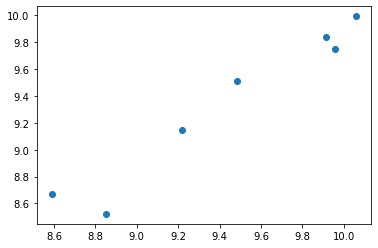

In [74]:
plt.scatter(predicted,actual)

In [75]:
dataset_norm = X_scaler.transform(arr)

In [77]:
pred = model.predict(dataset_norm)

In [78]:
act = arr2

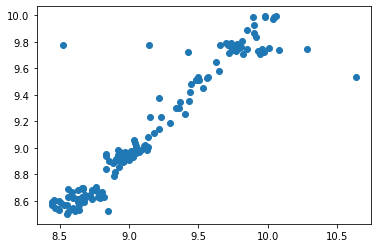

In [79]:
plt.scatter(pred, act)